In [12]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [13]:
import mkl
mkl.set_num_threads(1)
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    cut_off,
    power_law,
)
import mephisto
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from settings import LOCALPATH, BASEPATH, ngc1068, txs0506, plt
import settings as st
from likelihood import setup_multi_llh, ps_llh_multi
from matplotlib.colors import ListedColormap

# Settings

In [14]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    # "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    # "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    # "improved-20": join(LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"),
    "improved-50": join(LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"),
}



# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [15]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

# Background

In [16]:
with open(join(LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)
bckg_histo["Gen-2"] = copy(bckg_histo["IceCube"])

# Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

In [17]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1) # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1) # normalize per logE_true


# PSF-Energy grid from the smearing matrix

In [18]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

# Flux definition

In [19]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## NGC1068 and TXS0506 source parameters

In [20]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(BASEPATH, "local/ngc_paper_68_contour.txt"))
phi_c_68 /= 1E11

# TXS parameters
with open(join(BASEPATH, "local/txs_contour.pkl"), "rb") as f:
    txs_contour = pickle.load(f)

GAMMA_TXS = 2.
PHI_TXS = 2.7E-20
E0_TXS = txs_contour["E0"] 

ngc_flux = PL_flux(st.PHI_NGC, st.GAMMA_NGC, st.E0_NGC, "powerlaw")
txs_flux = PL_flux(PHI_TXS, GAMMA_TXS, E0_TXS, "powerlaw")


In [21]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=st.LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad

# ... with txs declination
txs_src_config = copy(src_config)
txs_src_config["dec"] = txs0506.dec.rad
txs_bg_config = copy(bg_config)
txs_bg_config["dec"] = txs0506.dec.rad


## Check event numbers

In [22]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
   10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=improved_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~88


## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **txs_src_config)
k_s = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=improved_eres,
    phi_scaling=1,
    flux_shape=txs_flux,
)
print("txs 0506+056:", np.sum(k_s))  # ~5

ngc 1068: 98.21015338126361
txs 0506+056: 5.4912645629339165


# Nominal & Improved PS fit

In [23]:
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for tmp_eres, key in product([baseline_eres, improved_eres], detector_keys):
    conf = st.detector_configurations[key]
    print(key)
    if np.all(tmp_eres == baseline_eres):
        print("Baseline Resolution")
    else:
        print("Improved Resolution")
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        eres=tmp_eres, conf=conf, bckg_histo=bckg_histo, src_flux=ngc_flux, aeff_2d=aeff_2d, bg_config=ngc_bg_config, sig_config=ngc_src_config
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Baseline Resolution
Atmo-only normalization: [1.06720859]
Signal fit parameters: [1.  1.  3.2]
TS check: -303610.6245645325 (fit:  -303610.6245645325 )
-2 Delta LLH: 22.14988576772157
P-VALUE: 1.5495779152563076e-05 SIGNIFICANCE: 4.166055279150261

Plenum-1
Baseline Resolution
Atmo-only normalization: [1.09227092]
Signal fit parameters: [1.  1.  3.2]
TS check: -1358596.0676056454 (fit:  -1358596.0676056454 )
-2 Delta LLH: 125.89580024033785
P-VALUE: 4.5927661226817185e-28 SIGNIFICANCE: 10.92063109019143

Plenum-2
Baseline Resolution
Atmo-only normalization: [1.07525711]
Signal fit parameters: [1.  1.  3.2]
TS check: -1316599.2441259185 (fit:  -1316599.2441259185 )
-2 Delta LLH: 271.644732615212
P-VALUE: 1.0306134206952897e-59 SIGNIFICANCE: 16.254924321374624

IceCube
Improved Resolution
Atmo-only normalization: [1.0672086]
Signal fit parameters: [1.  1.  3.2]
TS check: -278264.58393429866 (fit:  -278264.58393429866 )
-2 Delta LLH: 23.22616333863698
P-VALUE: 9.046960895351434e-0

# NGC cutoff parameter checks

In [46]:
# cutoff parameters
# see energy_spectrum_wiggle.ipynb for 'optimization'
# of these parameters
ident = "IceCube"

tmp_flux = PLcut_flux(
    st.PHI_NGC, st.Gamma_cut, st.logE_cut, st.E0_NGC, "powerlaw with cutoff"
)

## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        10 ** aeff_factor_signal.bin_mids[1],
        improved_eres,
        1,
        ngc_flux,
    )
)

# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        10 ** aeff_factor_signal.bin_mids[1],
        improved_eres,
        1,
        tmp_flux,
    )
)
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut) 
print("flux normalization before", st.PHI_NGC, "after", st.PHI_NGC * flux_scaling_cut)

# define the correctly normalized PL+cut flux for NGC 1068
# ngc_cut_flux = PLcut_flux(
#     st.PHI_NGC * flux_scaling_cut, st.Gamma_cut, st.logE_cut, st.E0_NGC, "powerlaw with cutoff"
# )


flux_scaling_cut 1.7835284935116167
flux normalization before 5e-14 after 8.917642467558084e-14


## pl-cut fit with pl significances

In [25]:
np.linspace(0.5, 1.5, num=11)

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5])

In [26]:
if False:
    ## Normalize on flux fit instead of ns

    # cutoff parameters
    Gamma_cuts = np.round(np.arange(1.6, 2.5, step=0.1), 2)
    logE_cuts = np.round(np.arange(3, 4.1, step=0.1), 2)  # log10 (Ecut / GeV)
    key = "IceCube" # "Plenum-1"  # 
    conf = (['IceCube'], [100]) #st.detector_configurations[key]

    es_ident = "improved"
    pvals_ngc = []

    for tmp_Gamma_cut, tmp_logE_cut in product(Gamma_cuts, logE_cuts):
        # define a temporary baseline flux for first fit iteration
        tmp_flux = PLcut_flux(st.PHI_NGC, tmp_Gamma_cut, tmp_logE_cut, st.E0_NGC, "powerlaw with cutoff")

        # PL fit to determine normalization
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
        ) = setup_multi_llh(
            improved_eres,
            conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=ngc_bg_config,
            sig_config=ngc_src_config,
            src_flux=tmp_flux,
        )

        dct = dict(
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=tmp_flux.E0,
        )

        pl_func = lambda x: ps_llh_multi(
            x,
            shape="powerlaw",
            phi_0=ngc_flux.norm,  # normalized with PL baseline flux,
            **dct,
        )
        _out = fmin_l_bfgs_b(
            pl_func,
            x0=(1.0, 1.0, 3.0),
            bounds=[(1E-2, 1E2), (1E-2, 1E2), (0.5, 6)],
            approx_grad=True,
        )

        flux_scaling_cut = 1 / _out[0][1]
        # define the newly normalized PL+cut flux for NGC 1068
        ngc_cut_flux_tmp = PLcut_flux(
            ngc_flux.norm * flux_scaling_cut, tmp_Gamma_cut, tmp_logE_cut, ngc_flux.E0, "powerlaw with cutoff"
        )

        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
        ) = setup_multi_llh(
            improved_eres,
            conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=ngc_bg_config,
            sig_config=ngc_src_config,
            src_flux=ngc_cut_flux_tmp,
        )

        dct = dict(
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=ngc_cut_flux_tmp.E0,
        )

        pl_func = lambda x: ps_llh_multi(
            x,
            shape="powerlaw",
            phi_0=ngc_flux.norm,  # normalized with PL baseline flux,
            **dct,
        )
        out_bckg = fmin_l_bfgs_b(
            pl_func,
            x0=(1.0, 1.0, 3.0),
            bounds=[(1E-2, 1E2), (1E-2, 1E2), (0.5, 6)],
            approx_grad=True,
        )
        atmo_func = lambda x: ps_llh_multi(
            (x[0], 0, 3),
            shape="powerlaw",
            phi_0=ngc_flux.norm,  # normalized with PL baseline flux,
            **dct,
        )
        out_atmo = fmin_l_bfgs_b(
            atmo_func,
            x0=(1.0, ),
            approx_grad=True,
        )

        global_llh = lambda x: ps_llh_multi(
            x,
            shape="powerlaw with cutoff",
            phi_0=ngc_cut_flux_tmp.norm,  # normalized with PL baseline flux,
            **dct,
        )
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, tmp_Gamma_cut, tmp_logE_cut),
            approx_grad=True,
        )

        # check the LLH at the "correct" parameter position
        check = global_llh((1, 1, tmp_Gamma_cut, tmp_logE_cut))
        pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
        pval_atmo = chi2.sf(out_atmo[1] - out_bckg[1], 1)
        pval_check = chi2.sf(out_bckg[1] - check, 1)
        pvals_ngc.append(
            {
                # "identifier": identifier,
                "e_smearing": es_ident,
                "pval": pval,
                "pval_atmo": pval,
                "pval_check": pval_check,
                "significance": norm.isf(pval),
                "significance_atmo": norm.isf(pval_atmo),
                "significance_check": norm.isf(pval_check),
                "gamma_cut": tmp_Gamma_cut,
                "logE_cut": tmp_logE_cut,
                "flux_scaling": flux_scaling_cut,
                "flux_cut_norm": st.PHI_NGC * flux_scaling_cut,
                "out_pl_gamma": out_bckg[0][2],
                "out_pl_norm": out_bckg[0][1],
                "out_plc_cut": out_comp[0][3],
                "out_plc_gamma": out_comp[0][2],
                "out_plc_norm": out_comp[0][1],
            }
        )
    pvals_ngc = pd.DataFrame(pvals_ngc)
    pd.to_pickle(pvals_ngc, join(BASEPATH, f"local/energy_cut_wiggle.pckl"))
else:
    # cutoff parameters
    Gamma_cuts = [2] #np.round(np.arange(1.6, 2.5, step=0.2), 2)
    logE_cuts = np.round(np.arange(3, 4.1, step=0.1), 2)  # log10 (Ecut / GeV)
    normalization = np.linspace(0.5, 1.5, num=11)
    conf = (["IceCube"], [10]) # just to get good fit results - multiply livetime by 10

    es_ident = "improved"
    pvals_ngc = []

    for tmp_Gamma_cut, tmp_logE_cut in product(Gamma_cuts, logE_cuts):
        # define a temporary baseline flux for first fit iteration
        tmp_flux = PLcut_flux(st.PHI_NGC, tmp_Gamma_cut, tmp_logE_cut, st.E0_NGC, "powerlaw with cutoff")

        ### scale the fluxes such that the event numbers match as first iteration
        flux_scaling_cut = np.sum(
            astro_flux(
                aeff_factor=aeff_factor_signal,
                emids=10 ** aeff_factor_signal.bin_mids[1],
                energy_resolution=None,
                phi_scaling=1,
                flux_shape=ngc_flux,
            )
        ) / np.sum(
            astro_flux(
                aeff_factor=aeff_factor_signal,
                emids=10 ** aeff_factor_signal.bin_mids[1],
                energy_resolution=None,
                phi_scaling=1,
                flux_shape=tmp_flux,
            )
        )
        for nz in normalization:
            # define the newly normalized PL+cut flux for NGC 1068
            ngc_cut_flux_tmp = PLcut_flux(
                st.PHI_NGC * flux_scaling_cut * nz, tmp_Gamma_cut, tmp_logE_cut, st.E0_NGC, "powerlaw with cutoff"
            )

            (
                all_aeff_factor_s,
                all_aeff_factor_b,
                all_k,
                all_bckg_flux,
                all_eres,
            ) = setup_multi_llh(
                improved_eres,
                conf,
                aeff_2d=aeff_2d,
                bckg_histo=bckg_histo,
                bg_config=ngc_bg_config,
                sig_config=ngc_src_config,
                src_flux=ngc_cut_flux_tmp,
            )

            dct = dict(
                all_aeff_factor_s=all_aeff_factor_s,
                all_aeff_factor_b=all_aeff_factor_b,
                all_k=all_k,
                all_bckg_flux=all_bckg_flux,
                all_eres=all_eres,
                e_0=ngc_cut_flux_tmp.E0,
            )

            pl_func = lambda x: ps_llh_multi(
                x,
                shape="powerlaw",
                phi_0=ngc_flux.norm,  # normalized with PL baseline flux,
                **dct,
            )
            out_bckg = fmin_l_bfgs_b(
                pl_func,
                x0=(1.0, 1.0, 3.0),
                approx_grad=True,
            )

            atmo_func = lambda x: ps_llh_multi(
                (x[0], 0, 3),
                shape="powerlaw",
                phi_0=ngc_flux.norm,  # normalized with PL baseline flux,
                **dct,
            )
            out_atmo = fmin_l_bfgs_b(
                atmo_func,
                x0=(1.0, ),
                approx_grad=True,
            )

            global_llh = lambda x: ps_llh_multi(
                x,
                shape="powerlaw with cutoff",
                phi_0=ngc_flux.norm,  # normalized with PL baseline flux,
                **dct,
            )
            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1, 1, ngc_cut_flux_tmp.gamma, ngc_cut_flux_tmp.e_cut),
                approx_grad=True,
            )

            # check the LLH at the "correct" parameter position
            check = global_llh((1, flux_scaling_cut * nz, ngc_cut_flux_tmp.gamma, ngc_cut_flux_tmp.e_cut))
            pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
            pval_atmo = chi2.sf(out_atmo[1] - out_bckg[1], 1)
            pval_check = chi2.sf(out_bckg[1] - check, 1)
            pvals_ngc.append(
                {
                    # "identifier": identifier,
                    "e_smearing": es_ident,
                    "pval": pval,
                    "pval_atmo": pval,
                    "pval_check": pval_check,
                    "significance": norm.isf(pval),
                    "significance_atmo": norm.isf(pval_atmo),
                    "significance_check": norm.isf(pval_check),
                    "gamma_cut": ngc_cut_flux_tmp.gamma,
                    "logE_cut": ngc_cut_flux_tmp.e_cut,
                    "flux_scaling": flux_scaling_cut,
                    "flux_cut_norm": ngc_cut_flux_tmp.norm,
                    "normalization_factor": nz, # for aggregation
                    "out_pl_gamma": out_bckg[0][2],
                    "out_pl_norm": out_bckg[0][1],
                    "out_plc_cut": out_comp[0][3],
                    "out_plc_gamma": out_comp[0][2],
                    "out_plc_norm": out_comp[0][1],
                }
            )
    pvals_ngc = pd.DataFrame(pvals_ngc)
    pd.to_pickle(pvals_ngc, join(BASEPATH, f"local/energy_cut_wiggle.pckl"))

## check for best fit parameters

In [27]:
# identifier = "Plenum-1"
pvals_ngc = pd.read_pickle(
    join(BASEPATH, f"local/energy_cut_wiggle.pckl")
)
pvals_ngc["gamma_pl_diff"] = pvals_ngc.out_pl_gamma - st.GAMMA_NGC
pvals_ngc["norm_pl_diff"] = pvals_ngc.out_pl_norm - 1
pvals_ngc["pcheck_ratio"] = pvals_ngc.pval / pvals_ngc.pval_check


In [28]:
pvals_ngc.pivot(
    columns="logE_cut",
    index="normalization_factor", 
    values="flux_cut_norm",
)

logE_cut,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0
normalization_factor,,,,,,,,,,,
0.5,1.161359e-13,8.931753e-14,6.982907e-14,5.541687e-14,4.458821e-14,3.633502e-14,2.996386e-14,2.498906e-14,2.106447e-14,1.793918e-14,1.542857e-14
0.6,1.393630e-13,1.071810e-13,8.379488e-14,6.650025e-14,5.350585e-14,4.360202e-14,3.595663e-14,2.998688e-14,2.527736e-14,2.152701e-14,1.851429e-14
0.7,1.625902e-13,1.250445e-13,9.776069e-14,7.758362e-14,6.242350e-14,5.086903e-14,4.194940e-14,3.498469e-14,2.949026e-14,2.511485e-14,2.160000e-14
0.8,1.858174e-13,1.429080e-13,1.117265e-13,8.866700e-14,7.134114e-14,5.813603e-14,4.794217e-14,3.998250e-14,3.370315e-14,2.870268e-14,2.468572e-14
0.9,2.090446e-13,1.607716e-13,1.256923e-13,9.975037e-14,8.025878e-14,6.540304e-14,5.393495e-14,4.498032e-14,3.791604e-14,3.229052e-14,2.777143e-14
1.0,2.322717e-13,1.786351e-13,1.396581e-13,1.108337e-13,8.917642e-14,7.267004e-14,5.992772e-14,4.997813e-14,4.212894e-14,3.587835e-14,3.085715e-14
1.1,2.554989e-13,1.964986e-13,1.536239e-13,1.219171e-13,9.809407e-14,7.993704e-14,6.592049e-14,5.497594e-14,4.634183e-14,3.946619e-14,3.394286e-14
1.2,2.787261e-13,2.143621e-13,1.675898e-13,1.330005e-13,1.070117e-13,8.720405e-14,7.191326e-14,5.997376e-14,5.055472e-14,4.305402e-14,3.702858e-14
1.3,3.019533e-13,2.322256e-13,1.815556e-13,1.440839e-13,1.159294e-13,9.447105e-14,7.790603e-14,6.497157e-14,5.476762e-14,4.664186e-14,4.011429e-14


In [29]:
ngc_flux.norm * 1.8

9.000000000000001e-14

In [30]:
pvals_ngc.pivot(
    columns="logE_cut",
    index="normalization_factor", 
    values="flux_scaling",
)

logE_cut,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0
normalization_factor,,,,,,,,,,,
0.5,4.645435,3.572701,2.793163,2.216675,1.783528,1.453401,1.198554,0.999563,0.842579,0.717567,0.617143
0.6,4.645435,3.572701,2.793163,2.216675,1.783528,1.453401,1.198554,0.999563,0.842579,0.717567,0.617143
0.7,4.645435,3.572701,2.793163,2.216675,1.783528,1.453401,1.198554,0.999563,0.842579,0.717567,0.617143
0.8,4.645435,3.572701,2.793163,2.216675,1.783528,1.453401,1.198554,0.999563,0.842579,0.717567,0.617143
0.9,4.645435,3.572701,2.793163,2.216675,1.783528,1.453401,1.198554,0.999563,0.842579,0.717567,0.617143
1.0,4.645435,3.572701,2.793163,2.216675,1.783528,1.453401,1.198554,0.999563,0.842579,0.717567,0.617143
1.1,4.645435,3.572701,2.793163,2.216675,1.783528,1.453401,1.198554,0.999563,0.842579,0.717567,0.617143
1.2,4.645435,3.572701,2.793163,2.216675,1.783528,1.453401,1.198554,0.999563,0.842579,0.717567,0.617143
1.3,4.645435,3.572701,2.793163,2.216675,1.783528,1.453401,1.198554,0.999563,0.842579,0.717567,0.617143


In [31]:
pivot_sigma = pvals_ngc.pivot(
    columns="logE_cut",
    index="normalization_factor", #"gamma_cut",
    values="significance",
    #aggfunc="max",
)
pivot_sigma_vsAtmo = pvals_ngc.pivot(
    columns="logE_cut",
    index="normalization_factor", #"gamma_cut",
    values="significance_atmo",
    #aggfunc="max",
)
pivot_gamma_diff = pvals_ngc.pivot(
    columns="logE_cut",
    index="normalization_factor", #"gamma_cut",
    values="gamma_pl_diff",
    #aggfunc="min",
)
pivot_norm_diff = pvals_ngc.pivot(
    columns="logE_cut",
    index="normalization_factor", #"gamma_cut",
    values="norm_pl_diff",
    #aggfunc="min",
)

In [32]:
pivot_norm_diff

logE_cut,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0
normalization_factor,,,,,,,,,,,
0.5,-0.524128,-0.513740,-0.504235,-0.495934,-0.489200,-0.484584,-0.482593,-0.483933,-0.488795,-0.497217,-0.509062
0.6,-0.427814,-0.415988,-0.405359,-0.396266,-0.389369,-0.385217,-0.384555,-0.387603,-0.394811,-0.406018,-0.421250
0.7,-0.331693,-0.318147,-0.306586,-0.297048,-0.290290,-0.286902,-0.287496,-0.292513,-0.302258,-0.316385,-0.334897
0.8,-0.235364,-0.220420,-0.207831,-0.198141,-0.191692,-0.189236,-0.191317,-0.198403,-0.210667,-0.227852,-0.249770
0.9,-0.139878,-0.122190,-0.109285,-0.099406,-0.093485,-0.092096,-0.095875,-0.105272,-0.120044,-0.140397,-0.165619
1.0,-0.041472,-0.024622,-0.010807,-0.000918,0.004358,0.004510,-0.006765,-0.012844,-0.030192,-0.053688,-0.082378
1.1,0.054575,0.073213,0.087572,0.097279,0.101862,0.100655,0.093181,0.079347,0.058950,0.032225,0.000105
1.2,0.151371,0.171085,0.185831,0.195261,0.199045,0.196394,0.187028,0.170626,0.147418,0.117698,0.082116
1.3,0.248242,0.268975,0.284074,0.293147,0.295944,0.291727,0.280281,0.261564,0.235296,0.202300,0.163214


In [33]:
pivot_sigma_vsAtmo

logE_cut,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0
normalization_factor,,,,,,,,,,,
0.5,6.622543,6.920722,7.308774,7.777020,8.316395,8.918625,9.576072,10.281463,11.027736,11.808010,12.615642
0.6,7.916802,8.266663,8.721240,9.268501,9.897040,10.596359,11.356766,12.169138,13.024782,13.915425,14.833272
0.7,9.186904,9.586689,10.105309,10.728316,11.441924,12.233408,13.091068,14.004012,14.962021,15.955556,16.975795
0.8,10.435394,10.883422,11.463750,12.159485,12.954456,13.833741,14.783688,15.791716,16.846182,17.936377,19.052554
0.9,11.664044,12.158731,12.798592,13.564287,14.437276,15.400481,16.438360,17.536721,18.682582,19.864150,21.070832
1.0,12.874236,13.414075,14.111447,14.944564,15.892544,16.936201,18.058046,19.242702,20.475567,21.743955,23.036492
1.1,14.067053,14.650647,15.403658,16.301869,17.322093,18.443083,19.645704,20.912747,22.228765,23.580004,24.954360
1.2,15.243424,15.869468,16.676380,17.637545,18.727510,19.923018,21.203222,22.549501,23.945261,25.375852,26.828485
1.3,16.404163,17.071432,17.930631,18.952777,20.110192,21.377659,22.732675,24.155254,25.627710,27.134540,28.662311


In [34]:
pivot_gamma_diff

logE_cut,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0
normalization_factor,,,,,,,,,,,
0.5,0.208540,0.140330,0.077230,0.018407,-0.036809,-0.089183,-0.139198,-0.187606,-0.234600,-0.280382,-0.325014
0.6,0.205183,0.135643,0.071374,0.011573,-0.044521,-0.097614,-0.148418,-0.197242,-0.244523,-0.290324,-0.335029
0.7,0.201863,0.131446,0.066231,0.005534,-0.051335,-0.105080,-0.156307,-0.205468,-0.252960,-0.298856,-0.343446
0.8,0.199027,0.127677,0.061626,0.000251,-0.057349,-0.111607,-0.163196,-0.212608,-0.260193,-0.306138,-0.350685
0.9,0.196399,0.124270,0.057408,-0.004644,-0.062680,-0.117382,-0.169296,-0.218980,-0.266588,-0.312585,-0.356996
1.0,0.193996,0.120986,0.053637,-0.009021,-0.067544,-0.122582,-0.176792,-0.224630,-0.272251,-0.318251,-0.362616
1.1,0.191491,0.118063,0.050085,-0.013034,-0.071930,-0.127300,-0.179692,-0.229579,-0.277361,-0.323381,-0.367646
1.2,0.189362,0.115361,0.046867,-0.016709,-0.075956,-0.131600,-0.184156,-0.234188,-0.281997,-0.327914,-0.372191
1.3,0.187377,0.112844,0.043883,-0.020111,-0.079697,-0.135556,-0.188299,-0.238376,-0.286248,-0.332156,-0.376308


## plotting

In [35]:
gamma_err = 0.2
norm_err = 0.2

In [36]:
sel = pivot_sigma[
    (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
]

print(sel.to_latex(float_format="%.2f"))

sel = sel[sel.columns[np.abs(sel.columns - 2) <= 0.21]]
sel = sel.loc[
    sel.index <= 3.7
]

print(sel.to_latex(float_format="%.1f"))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
logE_cut & 3.000000 & 3.100000 & 3.200000 & 3.300000 & 3.400000 & 3.500000 & 3.600000 & 3.700000 & 3.800000 & 3.900000 & 4.000000 \\
normalization_factor &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
0.500000 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\
0.600000 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\
0.700000 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\
0.800000 & NaN & NaN & NaN & 5.38 & 5.50 & 5.58 & 5.63 & NaN & NaN & NaN & NaN \\
0.900000 & 5.51 & 5.65 & 5.80 & 5.94 & 6.06 & 6.14 & 6.18 & NaN & NaN & NaN & NaN \\
1.000000 & 6.05 & 6.19 & 6.34 & 6.49 & 6.60 & 6.68 & 6.71 & NaN & NaN & NaN & NaN \\
1.100000 & 6.57 & 6.72 & 6.87 & 7.01 & 7.13 & 7.19 & 7.21 & NaN & NaN & NaN & NaN \\
1.200000 & 7.07 & 7.23 & 7.38 & 7.52 & 7.63 & 7.70 & 7.71 & NaN & NaN & NaN & NaN \\
1.300000 & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN & NaN \\
1.400000 & NaN & NaN & NaN &

In [37]:
# select roughly matching results
pivot_sigma[
    (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
]

# --> for gamma=2, ecut=3.4 yields a good separation,
# while still compatible within the IC error contour and bf result


logE_cut,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0
normalization_factor,,,,,,,,,,,
0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.8,NaN,NaN,NaN,5.379400,5.495429,5.582355,5.627191,NaN,NaN,NaN,NaN
0.9,5.510067,5.653558,5.801914,5.942880,6.059713,6.140286,6.177019,NaN,NaN,NaN,NaN
1.0,6.045691,6.193418,6.344579,6.486325,6.601738,6.676760,6.705235,NaN,NaN,NaN,NaN
1.1,6.566102,6.717196,6.870341,7.012164,7.125000,7.194517,7.213749,NaN,NaN,NaN,NaN
1.2,7.072701,7.226504,7.380908,7.522146,7.631899,7.695317,7.706182,NaN,NaN,NaN,NaN
1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
np.abs(pivot_norm_diff[
    (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
]).min()

logE_cut
3.0    0.041472
3.1    0.024622
3.2    0.010807
3.3    0.000918
3.4    0.004358
3.5    0.004510
3.6    0.006765
3.7         NaN
3.8         NaN
3.9         NaN
4.0         NaN
dtype: float64

In [39]:
# select roughly matching results
pivot_norm_diff[
    (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
]

# --> for gamma=2, ecut=3.4 yields a good separation,
# while still compatible within the IC error contour and bf result


logE_cut,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0
normalization_factor,,,,,,,,,,,
0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.8,NaN,NaN,NaN,-0.198141,-0.191692,-0.189236,-0.191317,NaN,NaN,NaN,NaN
0.9,-0.139878,-0.122190,-0.109285,-0.099406,-0.093485,-0.092096,-0.095875,NaN,NaN,NaN,NaN
1.0,-0.041472,-0.024622,-0.010807,-0.000918,0.004358,0.004510,-0.006765,NaN,NaN,NaN,NaN
1.1,0.054575,0.073213,0.087572,0.097279,0.101862,0.100655,0.093181,NaN,NaN,NaN,NaN
1.2,0.151371,0.171085,0.185831,0.195261,0.199045,0.196394,0.187028,NaN,NaN,NaN,NaN
1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
pivot_gamma_diff[
    (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
]

logE_cut,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0
normalization_factor,,,,,,,,,,,
0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.8,NaN,NaN,NaN,0.000251,-0.057349,-0.111607,-0.163196,NaN,NaN,NaN,NaN
0.9,0.196399,0.124270,0.057408,-0.004644,-0.062680,-0.117382,-0.169296,NaN,NaN,NaN,NaN
1.0,0.193996,0.120986,0.053637,-0.009021,-0.067544,-0.122582,-0.176792,NaN,NaN,NaN,NaN
1.1,0.191491,0.118063,0.050085,-0.013034,-0.071930,-0.127300,-0.179692,NaN,NaN,NaN,NaN
1.2,0.189362,0.115361,0.046867,-0.016709,-0.075956,-0.131600,-0.184156,NaN,NaN,NaN,NaN
1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# parameter choice

In [41]:
# parameter selection
baseline_selection = pvals_ngc.loc[
    (pvals_ngc.gamma_cut == 2)
    & np.isclose(pvals_ngc.normalization_factor, 1)
    & (pvals_ngc.logE_cut == 3.4)
]
print(baseline_selection)
flux_cut_norm = baseline_selection["flux_cut_norm"].values[0]

ngc_cut_flux = PLcut_flux(
    flux_cut_norm, st.Gamma_cut, st.logE_cut, st.E0_NGC, "powerlaw with cutoff"
)

   e_smearing          pval     pval_atmo    pval_check  significance  \
49   improved  2.031825e-11  2.031825e-11  2.031825e-11      6.601738   

    significance_atmo  significance_check  gamma_cut  logE_cut  flux_scaling  \
49          15.892544            6.601738          2       3.4      1.783528   

    flux_cut_norm  normalization_factor  out_pl_gamma  out_pl_norm  \
49   8.917642e-14                   1.0      3.132456     1.004358   

    out_plc_cut  out_plc_gamma  out_plc_norm  gamma_pl_diff  norm_pl_diff  \
49     3.399982       2.000021       1.78367      -0.067544      0.004358   

    pcheck_ratio  
49           1.0  


In [42]:
flux_cut_norm

8.917642467558084e-14

## with colored significance

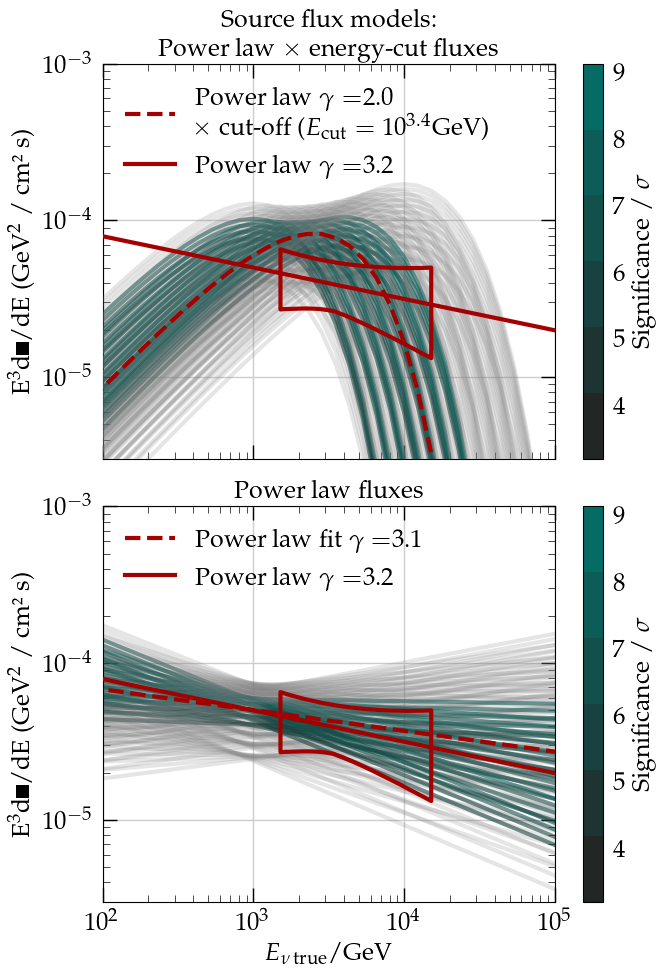

In [43]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 3

f, ax = plt.subplots(nrows=2, figsize=(7, 10), sharex=True)
ax[0].set_title("Source flux models: \n" + r"Power law $\times$ energy-cut fluxes")
ax[1].set_title("Power law fluxes")

cur_cmap = ListedColormap(
    sns.dark_palette(st.poles["P-ONE"]["color"], reverse=False, n_colors=6)
)

sigma_min = np.min(pvals_ngc.significance) #1
sigma_max = np.max(pvals_ngc.significance)
color_projection = lambda x: cur_cmap((x - sigma_min) / (sigma_max - sigma_min))
sm = plt.cm.ScalarMappable(
    cmap=cur_cmap, norm=plt.Normalize(vmin=sigma_min, vmax=sigma_max)
)
tmp_Gamma_cut = 2
for (tmp_nz, tmp_logE_cut), series in pvals_ngc.groupby(["normalization_factor", "logE_cut"]):
    ## selecting results that are close to the original fit values
    mask = (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
    if mask[tmp_logE_cut].loc[tmp_nz]:
        alpha_val = 0.6
        col = color_projection(series.iloc[0]["significance"])
    else:
        alpha_val = 0.2
        col = "gray"

    # define the correctly normalized PL+cut flux for NGC 1068
    ngc_cut_flux_tmp = PLcut_flux(
        series.iloc[0]["flux_cut_norm"], #st.PHI_NGC * series.iloc[0]["flux_scaling"],
        tmp_Gamma_cut,
        tmp_logE_cut,
        st.E0_NGC,
        "powerlaw with cutoff",
    )
    cut = power_law(
        x_evals, ngc_cut_flux_tmp.E0, ngc_cut_flux_tmp.gamma, ngc_cut_flux_tmp.norm
    ) * cut_off(x_evals, 10**ngc_cut_flux_tmp.e_cut)

    ax[0].plot(
        x_evals,
        cut * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=10,
        lw=3,
    )

    # define the correctly normalized PL flux for NGC 1068
    # using the parameters obtained when fitting the PL+cut flux with PL
    tmp_ngc_flux = PL_flux(
        st.PHI_NGC * series.iloc[0]["out_pl_norm"],
        series.iloc[0]["out_pl_gamma"],
        st.E0_NGC,
        "powerlaw",
    )

    pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

    ax[1].plot(
        x_evals,
        pl * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=1,
        lw=3,
    )
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

ax[0].plot(
    x_evals,
    cut * (x_evals**y_scaling),
    color=st.poles["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label=rf"Power law $\gamma=${ngc_cut_flux.gamma}"
    + "\n"
    + rf"$\times$ "
    + rf"cut-off ($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut:1.1f}}}$GeV)",
)

# PL fit from chosen ecut/gamma parameters
tmp_ngc_flux = PL_flux(
    st.PHI_NGC * baseline_selection.iloc[0]["out_pl_norm"],
    baseline_selection.iloc[0]["out_pl_gamma"],
    st.E0_NGC,
    "powerlaw",
)

pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

ax[1].plot(
    x_evals,
    pl * (x_evals**y_scaling),
    color=st.poles["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label=rf"Power law fit $\gamma=${tmp_ngc_flux.gamma:1.1f}",
)


# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)

for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, ngc_flux.E0, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)


for axx in ax:
    axx.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        edgecolor=st.poles["Plenum-2"]["color"],
        facecolor=(0, 0, 0, 0),
        lw=3,
        zorder=15,
    )
    axx.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"Power law $\gamma=${ngc_flux.gamma}",
        color=st.poles["Plenum-2"]["color"],
        alpha=1,
        zorder=10,
        lw=3,
    )

    axx.set_yscale("log")
    axx.set_ylabel(rf"$\rm E^{{{y_scaling}}} d\Phi / dE$ (GeV$^{{{y_scaling-1}}}$ / cm² s)")
    axx.set_xscale("log")
    if y_scaling == 3:
        axx.set_ylim(3e-6, 1e-3)
        axx.set_xlim(1e2, 1e5)
    elif y_scaling == 2:
        axx.set_ylim(1e-11, 1e-5)
        axx.set_xlim(1e2, 1e5)

    cb = plt.colorbar(sm, ax=axx)
    cb.set_label(r"Significance / $\sigma$")
    axx.legend(loc=2, frameon=False)
ax[1].set_xlabel(r"$E_{\nu \, \rm true}$/GeV")

f.tight_layout()
f.savefig(f"../../plots/ngc_paper/pl-cut_flux_model_matching_E{y_scaling}.pdf")

## with uni significance

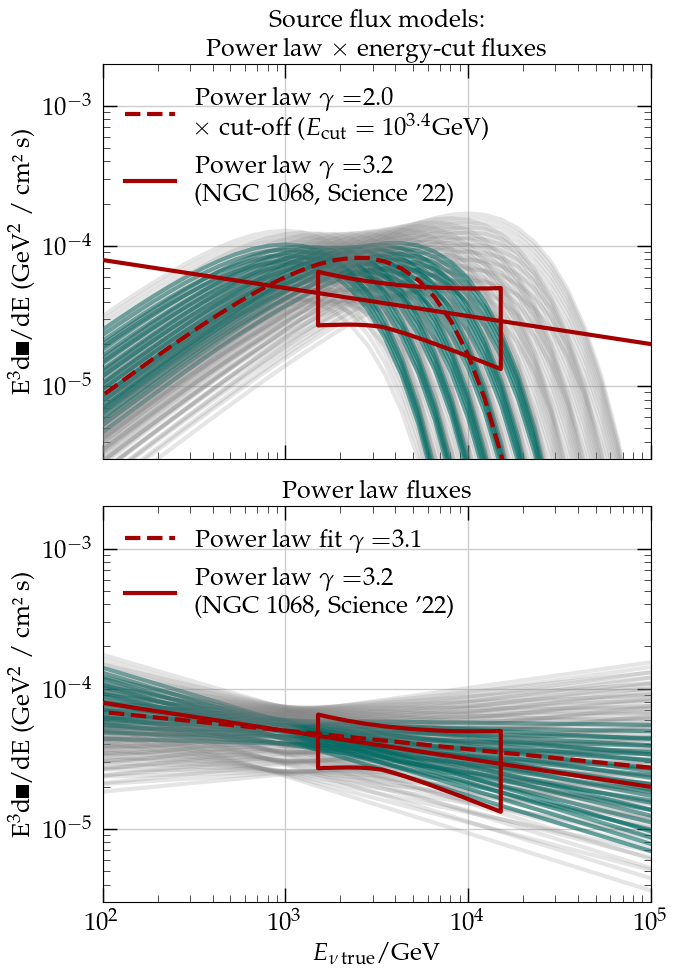

In [44]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 3

f, ax = plt.subplots(nrows=2, figsize=(7, 10), sharex=True)
ax[0].set_title("Source flux models: \n" + r"Power law $\times$ energy-cut fluxes")
ax[1].set_title("Power law fluxes")

current_color = st.colors[2]

tmp_Gamma_cut = 2
for (tmp_nz, tmp_logE_cut), series in pvals_ngc.groupby(["normalization_factor", "logE_cut"]):
    ## selecting results that are close to the original fit values
    mask = (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
    if mask[tmp_logE_cut].loc[tmp_nz]:
        alpha_val = 0.6
        col = current_color
    else:
        alpha_val = 0.2
        col = "gray"

    # define the correctly normalized PL+cut flux for NGC 1068
    ngc_cut_flux_tmp = PLcut_flux(
        series.iloc[0]["flux_cut_norm"], #st.PHI_NGC * series.iloc[0]["flux_scaling"],
        tmp_Gamma_cut,
        tmp_logE_cut,
        st.E0_NGC,
        "powerlaw with cutoff",
    )
    cut = power_law(
        x_evals, ngc_cut_flux_tmp.E0, ngc_cut_flux_tmp.gamma, ngc_cut_flux_tmp.norm
    ) * cut_off(x_evals, 10**ngc_cut_flux_tmp.e_cut)

    ax[0].plot(
        x_evals,
        cut * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=10,
        lw=3,
    )

    # define the correctly normalized PL flux for NGC 1068
    # using the parameters obtained when fitting the PL+cut flux with PL
    tmp_ngc_flux = PL_flux(
        st.PHI_NGC * series.iloc[0]["out_pl_norm"],
        series.iloc[0]["out_pl_gamma"],
        st.E0_NGC,
        "powerlaw",
    )

    pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

    ax[1].plot(
        x_evals,
        pl * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=1,
        lw=3,
    )
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

ax[0].plot(
    x_evals,
    cut * (x_evals**y_scaling),
    color=st.poles["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label=rf"Power law $\gamma=${ngc_cut_flux.gamma}"
    + "\n"
    + rf"$\times$ "
    + rf"cut-off ($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut:1.1f}}}$GeV)",
)

# PL fit from chosen ecut/gamma parameters
tmp_ngc_flux = PL_flux(
    st.PHI_NGC * baseline_selection.iloc[0]["out_pl_norm"],
    baseline_selection.iloc[0]["out_pl_gamma"],
    st.E0_NGC,
    "powerlaw",
)

pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

ax[1].plot(
    x_evals,
    pl * (x_evals**y_scaling),
    color=st.poles["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label=rf"Power law fit $\gamma=${tmp_ngc_flux.gamma:1.1f}",
)


# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)

for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, ngc_flux.E0, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)


for axx in ax:
    axx.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        edgecolor=st.poles["Plenum-2"]["color"],
        facecolor=(0, 0, 0, 0),
        lw=3,
        zorder=15,
    )
    axx.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=f"Power law $\gamma=${ngc_flux.gamma}\n(NGC 1068, Science '22)",
        color=st.poles["Plenum-2"]["color"],
        alpha=1,
        zorder=10,
        lw=3,
    )

    axx.set_yscale("log")
    axx.set_ylabel(rf"$\rm E^{{{y_scaling}}} d\Phi / dE$ (GeV$^{{{y_scaling-1}}}$ / cm² s)")
    axx.set_xscale("log")
    if y_scaling == 3:
        axx.set_ylim(3e-6, 2e-3)
        axx.set_xlim(1e2, 1e5)
    elif y_scaling == 2:
        axx.set_ylim(1e-11, 1e-5)
        axx.set_xlim(1e2, 1e5)

    axx.legend(loc=2, frameon=False)
ax[1].set_xlabel(r"$E_{\nu \, \rm true}$/GeV")

f.tight_layout()
f.savefig(f"../../plots/ngc_paper/pl-cut_flux_model_matching_E{y_scaling}_noCM.pdf")


In [45]:
raise BaseException(":)")

BaseException: :)

# Inoue's ICRC 2023 model
... and approximation

In [ ]:
from astropy.constants import h
import astropy.units as u
E = 1 * u.erg
nu = 1 * u.Hz
Enu = nu * h

# unit conversion
erg_to_GeV = E.to(u.GeV).value
nu_to_GeV = Enu.to(u.GeV).value
nu_to_erg = Enu.to(u.erg).value

print(erg_to_GeV, nu_to_GeV, nu_to_erg)

624.1509074460764 4.135667696923859e-24 6.62607015e-27


In [ ]:
from scipy.optimize import curve_fit
from scipy.interpolate import InterpolatedUnivariateSpline

In [ ]:
inoue_data = pd.read_csv(
    "/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/inoue_icrc2023.txt",
    skipinitialspace=True,
)
inoue_data["E_GeV"] = 10 ** (inoue_data["logE_eV"] - 9)
inoue_data["flux"] = (
    (10 ** inoue_data["E2_flux_erg"]) * 1E3 / (inoue_data["E_GeV"] ** 2)
)

spl_inoue = InterpolatedUnivariateSpline(np.log(inoue_data["E_GeV"]), np.log(inoue_data["flux"]))

[1.44266181e-04 2.42982317e+01 4.33298193e+01 6.92143191e-01
 3.92562671e-02]


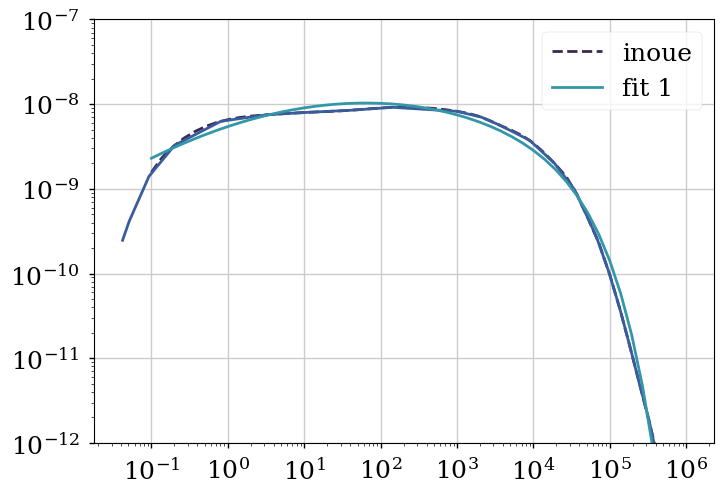

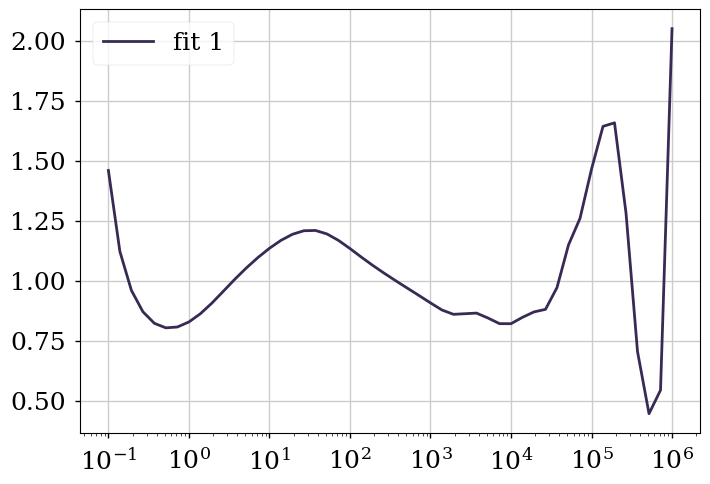

In [ ]:
x_evals = np.logspace(-1, 6)

plt.figure(1)
plt.loglog(
    x_evals,
    np.exp(spl_inoue(np.log(x_evals))) * (x_evals**2),
    label="inoue",
    ls="--",
)
plt.loglog(inoue_data["E_GeV"], inoue_data["flux"] * inoue_data["E_GeV"]**2)


func = (
    lambda E, gamma, norm, a, b, c: norm - gamma * (E**b) * np.log(E / 1e3) - a * (E**c)
)
fit, cov = curve_fit(func, x_evals, spl_inoue(np.log(x_evals)))
print(fit)
plt.figure(1)
plt.loglog(x_evals, np.exp(func(x_evals, *fit)) * (x_evals**2), label="fit 1")

plt.figure(2)
plt.plot(
    x_evals,
    np.exp(func(x_evals, *fit)) / np.exp(spl_inoue(np.log(x_evals))),
    label="fit 1",
    ls="-",
)

# func = lambda E, gamma, norm, a, b, c: norm - gamma * (E**b) * np.log(E / 1e3) - a / E
# fit, cov = curve_fit(func, x_evals, spl_inoue(np.log(x_evals)))
# print(fit)
# plt.figure(1)
# plt.loglog(x_evals, np.exp(func(x_evals, *fit))* (x_evals**2), label="fit 2")

# plt.figure(2)
# plt.plot(
#     x_evals,
#     np.exp(func(x_evals, *fit)) / np.exp(spl_inoue(np.log(x_evals))) * (x_evals**2),
#     label="fit 2",
#     ls=":",
# )

plt.figure(1)
#plt.xlim(10**2, None)
plt.ylim(1e-12, 1e-7)
plt.legend()

plt.figure(2)
#plt.xlim(10**2, None)
plt.xscale("log")
plt.legend()

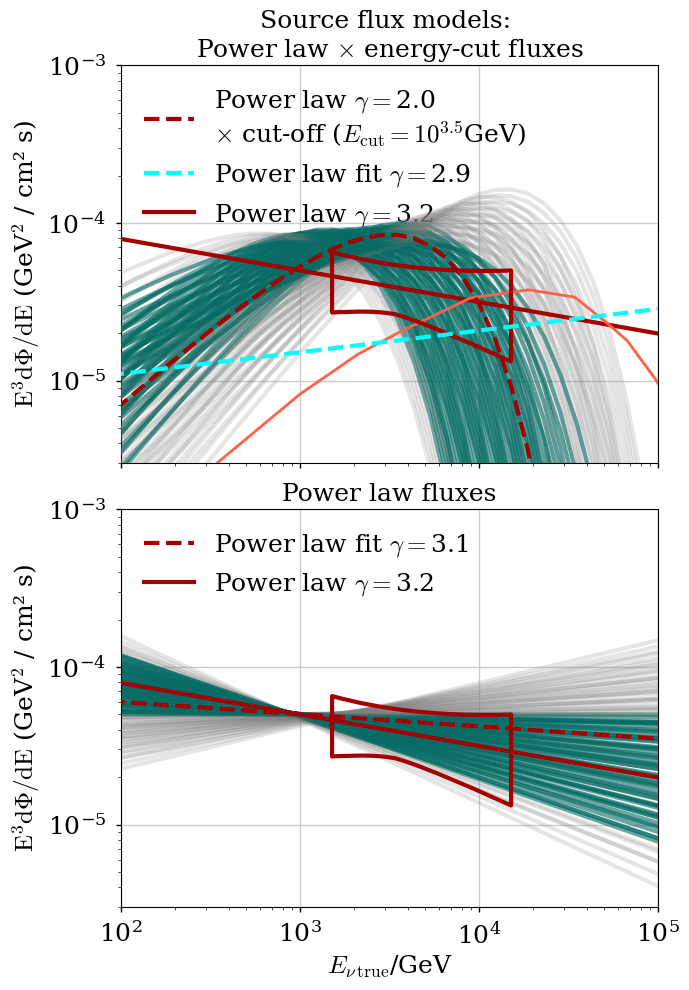

In [ ]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 3

f, ax = plt.subplots(nrows=2, figsize=(7, 10), sharex=True)
ax[0].set_title("Source flux models: \n" + r"Power law $\times$ energy-cut fluxes")
ax[1].set_title("Power law fluxes")

cur_color = st.colors[2] 

for (tmp_Gamma_cut, tmp_logE_cut), series in pvals_ngc.groupby(["gamma_cut", "logE_cut"]):
    ## selecting results that are close to the original fit values
    mask = (np.abs(pivot_gamma_diff) < gamma_err) & (np.abs(pivot_norm_diff) < norm_err)
    if mask[tmp_logE_cut].loc[tmp_Gamma_cut]:
        alpha_val = 0.6
        col = cur_color
    else:
        alpha_val = 0.2
        col = "gray"

    # define the correctly normalized PL+cut flux for NGC 1068
    ngc_cut_flux_tmp = PLcut_flux(
        st.PHI_NGC * series.iloc[0]["flux_scaling"],
        tmp_Gamma_cut,
        tmp_logE_cut,
        st.E0_NGC,
        "powerlaw with cutoff",
    )
    cut = power_law(
        x_evals, ngc_cut_flux_tmp.E0, ngc_cut_flux_tmp.gamma, ngc_cut_flux_tmp.norm
    ) * cut_off(x_evals, 10**ngc_cut_flux_tmp.e_cut)

    ax[0].plot(
        x_evals,
        cut * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=10,
        lw=3,
    )

    # define the correctly normalized PL flux for NGC 1068
    # using the parameters obtained when fitting the PL+cut flux with PL
    tmp_ngc_flux = PL_flux(
        st.PHI_NGC * series.iloc[0]["out_pl_norm"],
        series.iloc[0]["out_pl_gamma"],
        st.E0_NGC,
        "powerlaw",
    )

    pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

    ax[1].plot(
        x_evals,
        pl * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
        zorder=1,
        lw=3,
    )
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

ax[0].plot(
    x_evals,
    cut * (x_evals**y_scaling),
    color=st.poles["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label=rf"Power law $\gamma=${ngc_cut_flux.gamma}"
    + "\n"
    + rf"$\times$ "
    + rf"cut-off ($E_{{\rm cut}}=10^{{{ngc_cut_flux.e_cut:1.1f}}}$GeV)",
)

# PL fit from chosen ecut/gamma parameters
selection = pvals_ngc.loc[
    (pvals_ngc.gamma_cut == ngc_cut_flux.gamma)
    & (pvals_ngc.logE_cut == ngc_cut_flux.e_cut)
]
tmp_ngc_flux = PL_flux(
    st.PHI_NGC * selection.iloc[0]["out_pl_norm"],
    selection.iloc[0]["out_pl_gamma"],
    st.E0_NGC,
    "powerlaw",
)

pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

ax[1].plot(
    x_evals,
    pl * (x_evals**y_scaling),
    color=st.poles["Plenum-2"]["color"],
    ls="--",
    lw=3,
    zorder=20,
    label=rf"Power law fit $\gamma=${tmp_ngc_flux.gamma:1.1f}",
)

pl2 = power_law(x_evals, ngc_flux.E0, 2.86264914, ngc_flux.norm * 0.30305042)

ax[0].plot(
    x_evals,
    pl2 * (x_evals**y_scaling),
    color="cyan",
    ls="--",
    lw=3,
    zorder=20,
    label=rf"Power law fit $\gamma=${2.86264914:1.1f}",
)


# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)

for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, ngc_flux.E0, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)


for axx in ax:
    axx.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        edgecolor=st.poles["Plenum-2"]["color"],
        facecolor=(0, 0, 0, 0),
        lw=3,
        zorder=15,
    )
    axx.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"Power law $\gamma=${ngc_flux.gamma}",
        color=st.poles["Plenum-2"]["color"],
        alpha=1,
        zorder=10,
        lw=3,
    )

    axx.set_yscale("log")
    axx.set_ylabel(rf"$\rm E^{{{y_scaling}}} d\Phi / dE$ (GeV$^{{{y_scaling-1}}}$ / cm² s)")
    axx.set_xscale("log")
    if y_scaling == 3:
        axx.set_ylim(3e-6, 1e-3)
        axx.set_xlim(1e2, 1e5)
    elif y_scaling == 2:
        axx.set_ylim(1e-11, 1e-5)
        axx.set_xlim(1e2, 1e5)

    axx.legend(loc=2, frameon=False)
ax[1].set_xlabel(r"$E_{\nu \, \rm true}$/GeV")

ax[0].plot(
    inoue_data["E_GeV"],
    inoue_data["flux"] * (inoue_data["E_GeV"] ** y_scaling),
    color="tomato",
    zorder=10,
)

f.tight_layout()
# f.savefig(f"../../plots/ngc_paper/pl-cut_flux_model_matching_E{y_scaling}_noCM.pdf")

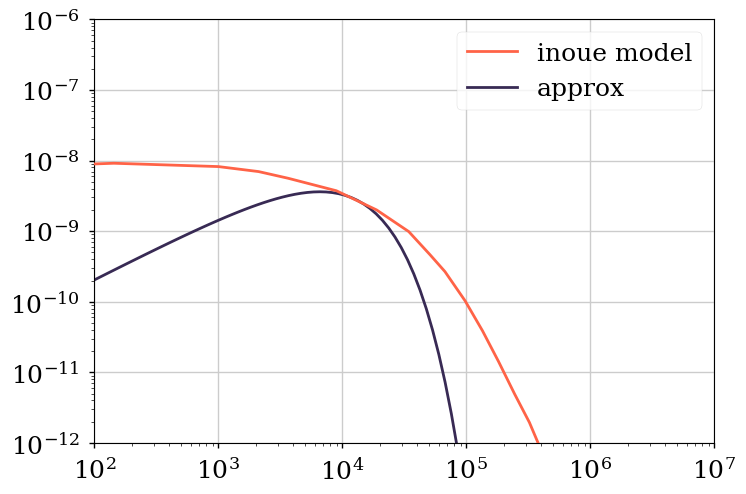

In [ ]:
y_scaling = 2

plt.loglog(
    inoue_data["E_GeV"],
    inoue_data["flux"] * (inoue_data["E_GeV"] ** y_scaling),
    color="tomato",
    zorder=10, label="inoue model"
)
x_evals = np.logspace(2, 7, 100)
# 0.02251359 1.10174637 3.86450213
plt.loglog(
    x_evals,
    power_law(x_evals, ngc_cut_flux.E0, 1.10174637, ngc_cut_flux.norm*0.02251359)
    * np.exp(-(x_evals/ 10**3.86450213)) #**0.75)
    * (x_evals**y_scaling), label="approx"
)
#plt.ylim(1E-21, 1E-11)
plt.ylim(1E-12, 1E-6)
plt.xlim(1E2, 1E7)
plt.legend()